In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
import os
results = np.load('/Users/sean/Downloads/2D_Wall_NoProp.npy')

In [ ]:
E = 3e10 #Pa
nu = 0.2 # Poisson's ratio
G = E / (2 * (1 + nu)) # Shear modulus
rho = 2400 # kg/m^3

mesh_size = 0.05

width = 5   # m
depth = 8   # m
t = 0.1     # m
D =  E * t**3 / (12 * (1 - nu**2))

x_prop = width / 2

H_exposed = 5.0
D_embed = 3.0
H_total = H_exposed + D_embed
L = H_total
EI = 20e6  # Nm²
gamma = 18.0 * 1e3  # N/m³
Ka = 0.333
Kp_mobilised = 1.5  # Reduced passive pressure coefficient
Kp = 3.0
z_prop = 2.5       # Depth of prop from top [m]
zR_prop = 60e3   # N/m (resisting direction, into wall)
zR_prop *= width

tol = 1e-7

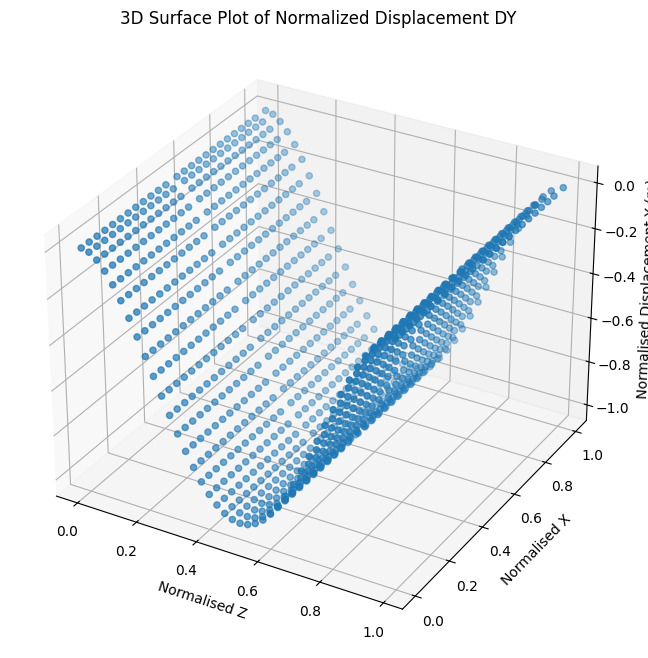

In [ ]:
x_raw, z_raw, y_raw = np.split(results, 3, axis = -1)

zdim_raw, xdim_raw = x_raw.shape[:2]
zdim, xdim = 40, 25
z_sample_index = np.linspace(0, zdim_raw-1, zdim, dtype=int)
x_sample_index = np.linspace(0, xdim_raw-1, xdim, dtype=int)

# Use meshgrid to create 2D indexing arrays
z_sample_mesh, x_sample_mesh = np.meshgrid(z_sample_index, x_sample_index, indexing='ij')

z_sampled_raw = z_raw[z_sample_mesh, x_sample_mesh]
x_sampled_raw = x_raw[z_sample_mesh, x_sample_mesh]
y_sampled_raw = y_raw[z_sample_mesh, x_sample_mesh]

z_max = np.max(z_raw[:,0])
x_max = np.max(x_raw[0])
y_max = np.max(abs(y_raw))

z_flatten = z_sampled_raw.flatten()
x_flatten = x_sampled_raw.flatten()
y_flatten = y_sampled_raw.flatten()

z_norm = z_sampled_raw / depth
x_norm = x_sampled_raw / width
y_norm = y_sampled_raw / y_max

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

z_norm = np.squeeze(z_norm, -1)
x_norm = np.squeeze(x_norm, -1)
y_norm = np.squeeze(y_norm, -1)

z_norm_flatten = z_norm.flatten()
x_norm_flatten = x_norm.flatten()
y_norm_flatten = y_norm.flatten()

results_norm_flatten = np.stack((z_norm_flatten, x_norm_flatten, y_norm_flatten), axis = -1)
# Create a scatter plot
surf = ax.scatter(z_norm_flatten, x_norm_flatten, y_norm_flatten)
# Add labels and title
ax.set_xlabel('Normalised Z')
ax.set_ylabel('Normalised X')
ax.set_zlabel('Normalised Displacement Y (m)')
ax.set_title('3D Surface Plot of Normalized Displacement DY')

plt.show()

In [ ]:
def q_soil_smooth(z, width=0.2):

    # Lines on either side of the break
    m1      =  Ka * gamma                                   # slope for z ≤ H
    m2      = (Ka - Kp_mobilised) * gamma                   # slope for z ≥ H
    c2      =  Kp_mobilised * gamma * H_exposed             # intercept so the
                                                            # two branches meet
    # Smooth switch 0→1 built from tanh
    w = 0.5 * (1 + np.tanh((z - H_exposed) / width))        # 0 left, 1 right

    return (1 - w) * (m1 * z) + w * (m2 * z + c2)
    
q_true = q_soil_smooth(z_flatten)
q_max = max(q_true)
q_norm = q_true / q_max


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
model = keras.Sequential([
    keras.layers.Input(shape = (2,)),
    keras.layers.Dense(32, activation='swish'),
    keras.layers.Dense(32, activation='swish'),
    keras.layers.Dense(32, activation='swish'),
    keras.layers.Dense(1)
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 8. Initialize b1, c1, b2, c2
m_a = tf.Variable(0.5, dtype=tf.float32)
m_p = tf.Variable(1, dtype=tf.float32)
m_prop = tf.Variable(1, dtype=tf.float32)


# --- 9. Learning Rate Scheduler ---
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, # Slightly lower initial LR
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


physics loss

In [ ]:

def laplacian(inputs, func = model):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(inputs)
        with tf.GradientTape() as tape1:
            tape1.watch(inputs)
            f = func(inputs)
        grad = tape1.gradient(f, inputs)  # shape (N, D)
        dz, dx = tf.unstack(grad, axis = -1)
    
    dz2 = tf.unstack(tape2.gradient(dz, inputs), axis = -1)[0]
    dx2 = tf.unstack(tape2.gradient(dx, inputs), axis = -1)[1]
    
    return dz2 + dx2


def first_order_grad(inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        f = model(inputs)
    g = tape.gradient(f, inputs)
    return g

In [ ]:
def piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf):  #input normalized
    z_phys = z_norm_flatten_tf * z_max
    q_total = tf.where(z_phys <= H_exposed, (m_a * gamma * Ka * z_phys), (m_a * gamma * Ka * z_phys - m_p*gamma*Kp*(z_phys-H_exposed)))
    return q_total

In [ ]:
N_DATA_ONLY_EPOCHS = 500
N_BC_EPOCHS = 300
N_PHYSICS_EPOCHS = 200

@tf.function

def train_step(batch, epoch_val):
  z, x , y_true = batch[:,0], batch[:,1], batch[:,2]

  with tf.GradientTape() as tape:
    zxstack = tf.stack((z, x), axis = -1)
    y_pred = model(zxstack)
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    gradz, gradx = tf.unstack(first_order_grad(zxstack), axis = -1)
    bc_disp = tf.reduce_sum(tf.square(y_pred[:xdim]) + tf.square(y_pred[-xdim:]))
    bc_z_loss = tf.reduce_mean(tf.square(gradz[:xdim]) + tf.square(gradz[-xdim:]))
    bc_x_boundaries = tf.square([gradx[i] for i in range(z.shape[0]) if i % xdim ==0 or (i+1) % xdim == 0])
    bc_x_loss = tf.reduce_sum(bc_x_boundaries) 
    bc_loss = bc_disp + bc_z_loss + bc_x_loss
      
    biharmonic = laplacian(tf.stack((z,x), axis = -1), laplacian)
    q_pred = piecewise_q(z,x)
    physics_residual = tf.square(biharmonic * D * y_max / q_max - q_pred / q_max)
    physics_loss = tf.reduce_mean(physics_residual)

    if epoch_val < N_DATA_ONLY_EPOCHS:
        w_data, w_phys, w_bc = 1.0, 0.1, 0.0
    elif epoch_val < N_BC_EPOCHS:
        w_data, w_phys, w_bc = 0.2, 1.0, 0.0
    else:
        w_data, w_phys, w_bc = 0.2, 1.0, 0.5
        
    loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss

  variables = model.trainable_variables + [m_a, m_p]
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  del tape
  return loss, data_loss, bc_loss, physics_loss

In [ ]:
# --- 0. batching parameters --------------------------------------------
BATCH_SIZE  = 1024
SHUFFLE_BUF = 10_000

dataset = (tf.data.Dataset.from_tensor_slices(
              tf.convert_to_tensor(results_norm_flatten, dtype=tf.float32))
           .shuffle(SHUFFLE_BUF, reshuffle_each_iteration=True)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))

# --- 1. history containers ---------------------------------------------
history        = {k: [] for k in ["loss", "data", "phys", "bc"]}
history_params = {"m_a": [], "m_p": []}

# --- 2. training loop ---------------------------------------------------
for epoch in range(1000):
    # We’ll keep the metrics from the *last* batch in this epoch
    for batch in dataset:
        loss, data_l, bc_l, phys_l = train_step(batch, epoch)

    # record those metrics (no division → no ZeroDivisionError)
    history["loss"].append(float(loss.numpy()))
    history["data"].append(float(data_l.numpy()))
    history["phys"].append(float(phys_l.numpy()))
    history["bc"].append(float(bc_l.numpy()))
    history_params["m_a"].append(m_a.numpy())
    history_params["m_p"].append(m_p.numpy())

    if epoch % 5 == 0:
        print(f"Epoch {epoch:3d} | "
              f"loss {loss.numpy():.3e} | "
              f"data {data_l.numpy():.3e} | "
              f"bc {bc_l.numpy():.3e} | "
              f"phys {phys_l.numpy():.3e}")


2025-08-07 15:42:05.264900: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch   0 | loss 6.069e-01 | data 3.983e-01 | bc 1.162e-02 | phys 2.086e+00


2025-08-07 15:42:08.159939: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-07 15:42:13.873636: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch   5 | loss 5.695e-01 | data 3.631e-01 | bc 5.005e-02 | phys 2.064e+00


2025-08-07 15:42:25.255247: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  10 | loss 5.353e-01 | data 3.309e-01 | bc 2.582e-01 | phys 2.044e+00


2025-08-07 15:42:48.431119: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  15 | loss 5.036e-01 | data 3.011e-01 | bc 6.566e-01 | phys 2.025e+00
Epoch  20 | loss 4.740e-01 | data 2.734e-01 | bc 1.163e+00 | phys 2.007e+00
Epoch  25 | loss 4.464e-01 | data 2.475e-01 | bc 1.863e+00 | phys 1.989e+00
Epoch  30 | loss 4.208e-01 | data 2.236e-01 | bc 3.029e+00 | phys 1.972e+00


2025-08-07 15:43:33.654216: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  35 | loss 3.973e-01 | data 2.018e-01 | bc 3.938e+00 | phys 1.955e+00
Epoch  40 | loss 3.761e-01 | data 1.825e-01 | bc 5.395e+00 | phys 1.936e+00
Epoch  45 | loss 3.576e-01 | data 1.662e-01 | bc 7.227e+00 | phys 1.914e+00
Epoch  50 | loss 3.422e-01 | data 1.532e-01 | bc 9.060e+00 | phys 1.890e+00
Epoch  55 | loss 3.299e-01 | data 1.437e-01 | bc 1.157e+01 | phys 1.862e+00
Epoch  60 | loss 3.205e-01 | data 1.375e-01 | bc 1.337e+01 | phys 1.830e+00


KeyboardInterrupt: 

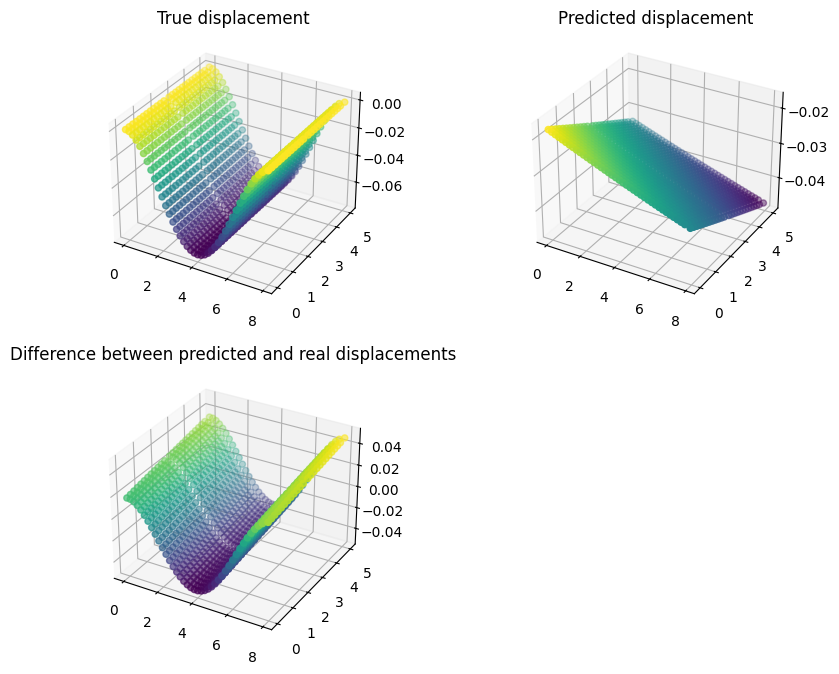

In [ ]:
z_norm_flatten_tf = tf.convert_to_tensor(z_norm_flatten, dtype=tf.float32)
x_norm_flatten_tf = tf.convert_to_tensor(x_norm_flatten, dtype=tf.float32)

zxstack = tf.stack((z_norm_flatten_tf, x_norm_flatten_tf), axis = -1)

y_pred_norm = model(zxstack)
y_pred_norm = np.squeeze(y_pred_norm, -1)
y_pred = y_pred_norm * y_max

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(221, projection = '3d')
ax1.scatter(z_flatten, x_flatten, y_flatten, c = y_flatten, cmap = 'viridis')
ax1.set_title('True displacement')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(z_flatten, x_flatten, y_pred, c=y_pred_norm, cmap='viridis')
ax2.set_title('Predicted displacement')

diff = y_flatten - y_pred

ax3 = fig.add_subplot(223, projection = '3d')
ax3.scatter(z_flatten, x_flatten, diff, c = diff, cmap = 'viridis')
ax3.set_title('Difference between predicted and real displacements')

plt.show()

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5668951869010925> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.6783506870269775>


Text(0.5, 0.92, 'predicted loading from variables')

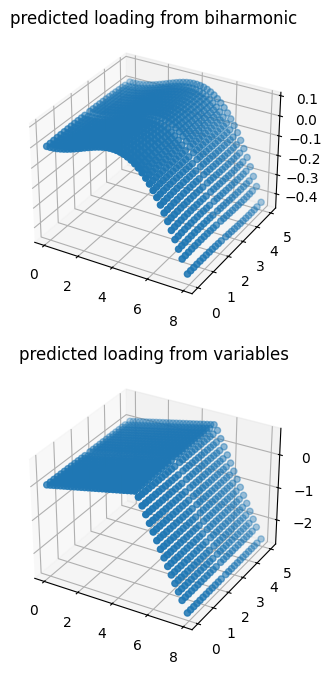

In [ ]:
bih = laplacian(zxstack, laplacian)

cut = 0
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211, projection = '3d')
ax1.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], bih[cut*xdim:])
ax1.set_title('predicted loading from biharmonic')

print(m_a, m_p)

q_params = piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf)
ax1 = fig.add_subplot(212, projection = '3d')
ax1.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], q_params[cut*xdim:]/q_max)
ax1.set_title('predicted loading from variables')

NameError: name 'W1_DATA' is not defined

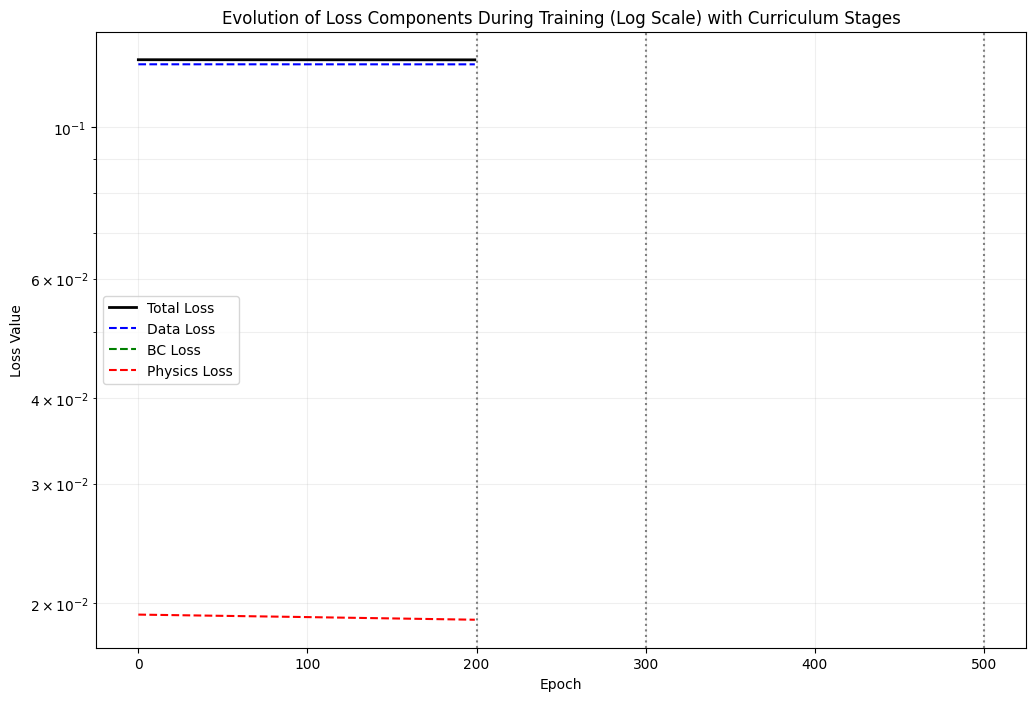

In [ ]:
# --- Plotting Loss History with Stages ---
plt.figure(figsize=(12, 8))

# Plot Total Loss
plt.plot(history["loss"], label="Total Loss", color='black', linewidth=2)

# Plot Individual Loss Components
plt.plot(history["data"], label="Data Loss", color='blue', linestyle='--')
plt.plot(history["bc"], label="BC Loss", color='green', linestyle='--')
plt.plot(history["phys"], label="Physics Loss", color='red', linestyle='--')
# Uncomment if you have continuity loss
# plt.plot(history["cont"], label="Continuity Loss", color='purple', linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Evolution of Loss Components During Training (Log Scale) with Curriculum Stages")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

# Vertical lines to mark transitions
plt.axvline(N_DATA_ONLY_EPOCHS, color='gray', linestyle=':', linewidth=1.5)
plt.axvline(N_BC_EPOCHS, color='gray', linestyle=':', linewidth=1.5)
plt.axvline(N_PHYSICS_EPOCHS, color='gray', linestyle=':', linewidth=1.5)

# --- Annotations with Curriculum Weights ---
ymin, ymax = plt.ylim()
text_y_pos_log = 10 ** (np.log10(ymax) - 0.1 * (np.log10(ymax) - np.log10(ymin)))  # 90% of height

# Phase 1: Data Only
plt.text(N_DATA_ONLY_EPOCHS / 2, text_y_pos_log,
         f"Phase 1: Data Only\nData={W1_DATA:.1f}, Phys={W1_PHYS:.1f}, BC={W1_BC:.1f}",
         ha='center', va='top',
         bbox=dict(boxstyle="round,pad=0.3", fc='yellow', alpha=0.5), fontsize=8)

# Phase 2: Add BC
plt.text(N_DATA_ONLY_EPOCHS + (N_BC_EPOCHS - N_DATA_ONLY_EPOCHS) / 2, text_y_pos_log,
         f"Phase 2: BCs\nData={W2_DATA:.1f}, Phys={W2_PHYS:.1f}, BC={W2_BC:.1f}",
         ha='center', va='top',
         bbox=dict(boxstyle="round,pad=0.3", fc='lightgreen', alpha=0.5), fontsize=8)

# Phase 3: Full Physics
plt.text(N_BC_EPOCHS + (N_PHYSICS_EPOCHS - N_BC_EPOCHS) / 2, text_y_pos_log,
         f"Phase 3: Physics\nData={W3_DATA:.1f}, Phys={W3_PHYS:.1f}, BC={W3_BC:.1f}",
         ha='center', va='top',
         bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.5), fontsize=8)

plt.tight_layout()
plt.show()